# Шаг 0. Импорт

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, mean_squared_error, silhouette_score, mean_absolute_error
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from sklearn.metrics import r2_score, f1_score

from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.tree import plot_tree

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import VotingRegressor, BaggingRegressor, StackingRegressor
import itertools

import joblib
from tqdm.notebook import tqdm
from sklearn.preprocessing import OneHotEncoder
from collections import Counter

# Шаг 1. Считывание данных и бинаризация рейтинга

In [4]:
df = pd.read_csv('../data/clean_epi_r.csv')
df.head(1)

,title,rating,calories,protein,fat,sodium,alcoholic,almond,apple,apricot,...,no-cook,slow cooker,pressure cooker,grill,bake,roast,broil,braise,quick & easy.1,advance prep required
0,"Lentil, Apple, and Turkey Wrap",2.5,426.0,30.0,7.0,559.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
ingredients = pd.read_csv('../data/popular_real_ingredients.csv')

In [6]:
ingredients_list = ingredients['0'].to_list()

In [7]:
result_vector = ingredients_list + ['protein', 'sodium']

# Шаг 2. Обучение модели на округленных целочисленных столбцах

In [8]:
important_column = ['title', 'rating', 'calories', 'protein', 'fat', 'sodium']
df = df.fillna(0)

In [9]:
target = df['rating']
features = df.drop(['title', 'rating', 'calories', 'fat'], axis=1)
features = features.loc[:, ~features.columns.duplicated()]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=21)

In [45]:
features

,protein,sodium,alcoholic,almond,apple,apricot,arugula,asparagus,avocado,bacon,...,no-cook,slow cooker,pressure cooker,grill,bake,roast,broil,braise,quick & easy.1,advance prep required
0,30.0,559.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,18.0,1439.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,6.0,165.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,20.0,452.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20047,2.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20048,22.0,583.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20049,31.0,652.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
20050,45.0,517.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Фун-я для обучения моделей

In [11]:
def train_all_models(models, X_train, X_test, y_train, y_test):

    results = {}
    best_models = {}

    for model_config in tqdm(models, desc='Training models'):
        name = model_config['name']
        print(f'Training {name}')

        grid_search = GridSearchCV(
            estimator=model_config['pipeline'],
            param_grid=model_config['params'],
            cv=5,
            scoring='accuracy',
            n_jobs=-1,
            verbose=0
        )

        grid_search.fit(X_train, y_train)

        best_models[name] = grid_search.best_estimator_

        y_pred = grid_search.predict(X_test)

        metrics = {
            'Accuracy': accuracy_score(y_test, y_pred),
            'F1_Score': f1_score(y_test, y_pred,average='weighted'),
            'CV_Accuracy': grid_search.best_score_,
            'Best_Params': grid_search.best_params_
        }

        results[name] = metrics

        print(f"   Best CV Accuracy: {metrics['CV_Accuracy']:.4f}")
        print(f"   Test Accuracy: {metrics['Accuracy']:.4f}")
        print(f"   Test F1-Score: {metrics['F1_Score']:.4f}")
        print(f"   Best parameters: {grid_search.best_params_}")
        print()
        print()

    return results, best_models

### Фун-я конвертирования оценок на 3 класса

In [12]:
def convert_to_3class(y):
    y_3class = np.zeros_like(y)

    y_3class[y <= 2] = 0
    y_3class[(y > 2) & (y < 4)] = 1
    y_3class[y >= 4] = 2
    return y_3class

### Конвертирование оценок на 3 класса

In [13]:
y_train_round = np.round(y_train).astype(int)
y_test_round = np.round(y_test).astype(int)

In [14]:
y_train_3class = convert_to_3class(y_train_round)
y_test_3class = convert_to_3class(y_test_round)

In [15]:
np.unique(y_train_3class), np.unique(y_test_3class)

(array([0, 1, 2]), array([0, 1, 2]))

In [16]:
train_counts = pd.Series(np.ravel(y_train_3class)).value_counts().sort_index()
test_counts = pd.Series(np.ravel(y_test_3class)).value_counts().sort_index()

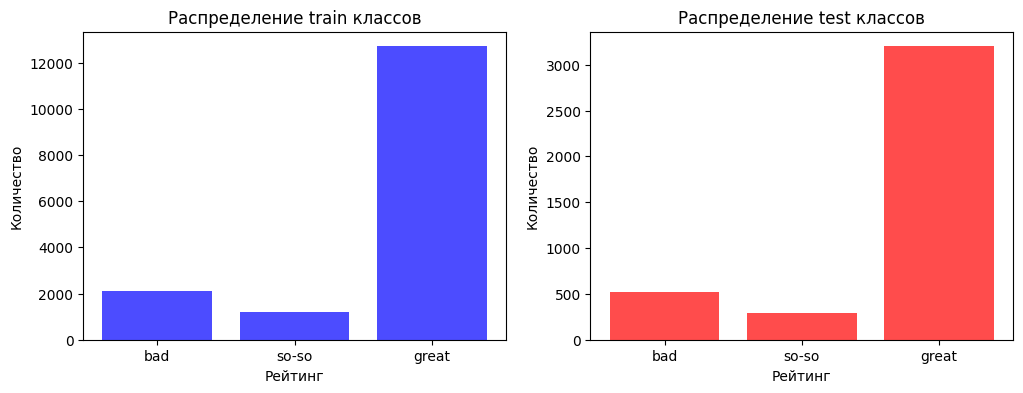

In [17]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.bar(train_counts.index, train_counts.values, alpha=0.7, color='blue')
plt.title('Распределение train классов')
plt.xlabel('Рейтинг')
plt.ylabel('Количество')
plt.xticks([0, 1, 2], ['bad', 'so-so', 'great'])

plt.subplot(1, 2, 2)
plt.bar(test_counts.index, test_counts.values, alpha=0.7, color='red')
plt.title('Распределение test классов')
plt.xlabel('Рейтинг')
plt.ylabel('Количество')
plt.xticks([0, 1, 2], ['bad', 'so-so', 'great'])


plt.show()

### Считаем наивный классификатор

In [18]:
unique, counts = np.unique(y_train_3class, return_counts=True)
most_common_class = unique[np.argmax(counts)]

In [19]:
naive_predictions = np.full_like(y_test_3class, most_common_class)

In [20]:
naive_accuracy = accuracy_score(y_test_3class, naive_predictions)
naive_f1 = f1_score(y_test_3class, naive_predictions, average='weighted')
naive_accuracy, naive_f1

(0.7978060334081276, 0.708079131023716)

### Обучение моделей на 3 классах

In [21]:
num_features = ['protein', 'sodium']
binary_features = [el for el in features.columns if el not in num_features]

preprocess = ColumnTransformer(
    [
        ('num', StandardScaler(), num_features),
        ('bin', 'passthrough', binary_features)
    ]
)

In [22]:
logreg_one_model_pipeline = {
    'name': 'LogisticRegression',
    'pipeline': Pipeline([
        ('preprocess', preprocess),
        ('model', LogisticRegression(random_state=21, max_iter=1000))
    ]),
    'params': {
        'model__C': [1.0],
        'model__solver': ['liblinear']
    }
}

random_forest_one_model_pipeline = {
    'name': 'RandomForest',
    'pipeline': Pipeline([
        ('preprocess', preprocess),
        ('model', RandomForestClassifier(random_state=21, n_jobs=-1))
    ]),
    'params': {
        'model__n_estimators': [100],
        'model__max_depth': [50],
        'model__class_weight': [None],
        'model__criterion': ['entropy']
    }
}

tree_one_model_pipeline = {
    'name': 'DecisionTree',
    'pipeline': Pipeline([
        ('preprocess', preprocess),
        ('model', DecisionTreeClassifier(random_state=21))
    ]),
    'params': {
        'model__max_depth': [20],
        'model__class_weight': [None],
        'model__criterion': ['gini'],
        'model__min_samples_split': [2],

    }
}

In [23]:
classifiers_3class = [logreg_one_model_pipeline, random_forest_one_model_pipeline, tree_one_model_pipeline]

In [24]:
result_3class, model_3class = train_all_models(classifiers_3class, X_train, X_test, y_train_3class, y_test_3class)

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Training LogisticRegression
   Best CV Accuracy: 0.8013
   Test Accuracy: 0.8048
   Test F1-Score: 0.7327
   Best parameters: {'model__C': 1.0, 'model__solver': 'liblinear'}


Training RandomForest
   Best CV Accuracy: 0.8221
   Test Accuracy: 0.8285
   Test F1-Score: 0.7864
   Best parameters: {'model__class_weight': None, 'model__criterion': 'entropy', 'model__max_depth': 50, 'model__n_estimators': 100}


Training DecisionTree
   Best CV Accuracy: 0.7675
   Test Accuracy: 0.7764
   Test F1-Score: 0.7387
   Best parameters: {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 20, 'model__min_samples_split': 2}




### Ансамбль

In [25]:
voiting_estimators = [
    ('logreg', model_3class['LogisticRegression']),
    ('random_forest', model_3class['RandomForest']),
    ('decision_tree', model_3class['DecisionTree'])
]

In [27]:
voting_model = VotingClassifier(estimators=voiting_estimators, weights=[2,3,4])

In [28]:
voting_model.fit(X_train, y_train_3class)

VotingClassifier(estimators=[('logreg',
                              Pipeline(steps=[('preprocess',
                                               ColumnTransformer(transformers=[('num',
                                                                                StandardScaler(),
                                                                                ['protein',
                                                                                 'sodium']),
                                                                               ('bin',
                                                                                'passthrough',
                                                                                ['alcoholic',
                                                                                 'almond',
                                                                                 'apple',
                                                                        

In [29]:
best_voting_model = voting_model
y_pred_best_voiting_model = best_voting_model.predict(X_test)

### Метрики для voting classifier

In [34]:
accuracy_score(y_test_3class, y_pred_best_voiting_model), f1_score(y_test_3class, y_pred_best_voiting_model, average='weighted')

(0.8115183246073299, 0.7526417954437493)

In [39]:
naive_accuracy, naive_f1

(0.7978060334081276, 0.708079131023716)

### Метрики для random forest

In [40]:
y_pred_rf = model_3class['RandomForest'].predict(X_test)

In [41]:
accuracy_score(y_test_3class, y_pred_rf), f1_score(y_test_3class, y_pred_rf, average='weighted')

(0.8284717028172526, 0.7864269316913702)

In [42]:
naive_accuracy, naive_f1

(0.7978060334081276, 0.708079131023716)

### Сохранение модели

In [43]:
feature_columns = X_train.columns.tolist()

In [ ]:
joblib.dump({'model': model_3class['RandomForest'], 'features_column': feature_columns}, '../final_models/clean_model_classification.pkl')

['../final_models/clean_model.pkl']